In [1]:
pip install torch torchvision torchaudio


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/syonamehra/HRTStep1/trading_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

Epoch [100/500], Loss: 5.991717
Epoch [200/500], Loss: 1.444302
Epoch [300/500], Loss: 0.488381
Epoch [400/500], Loss: 0.278460
Epoch [500/500], Loss: 0.194207


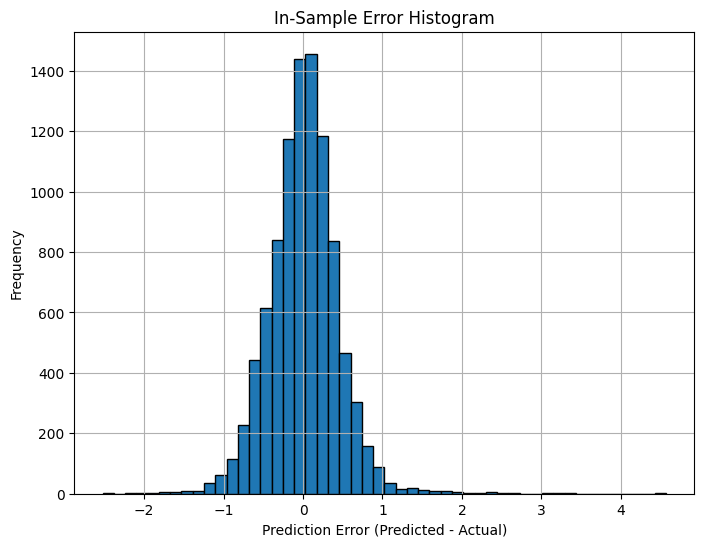

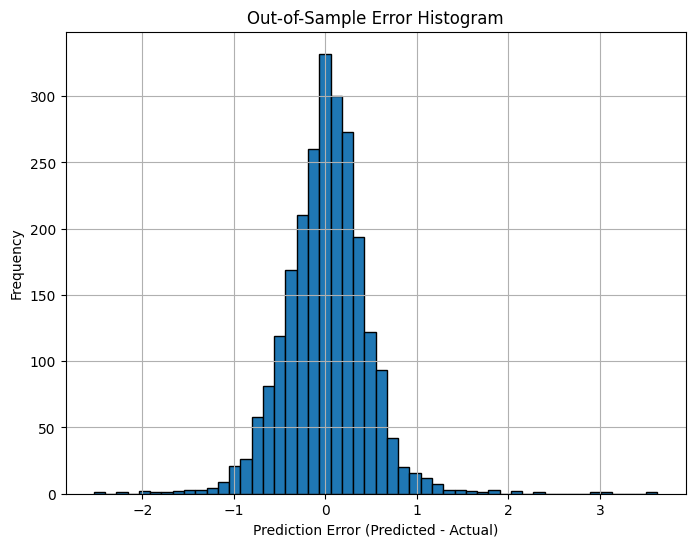

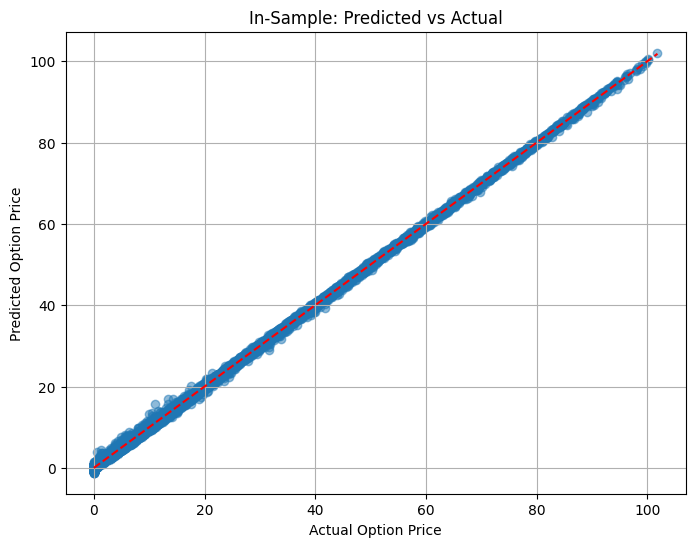

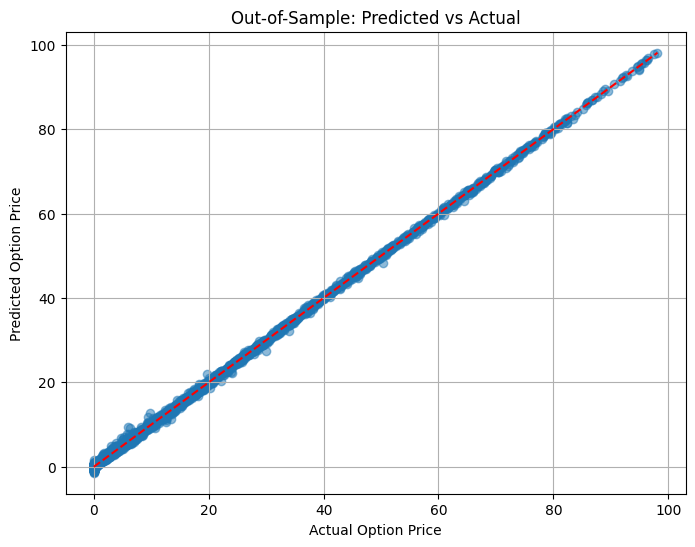


Analysis:
In-Sample MSE: 0.193701, MAE: 0.326054
Out-of-Sample MSE: 0.206912, MAE: 0.333211
  Metric  In-Sample  Out-of-Sample
0    MSE   0.193701       0.206912
1    MAE   0.326054       0.333211


In [10]:
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Black-Scholes Function
def black_scholes_call(S, K, T, r, sigma):
    """
    Computes the Black-Scholes price for a European call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Step 2: Generate Synthetic Data
def generate_data(num_samples=12000):
    """
    Samples random BS parameters and computes option prices.
    Ranges are typical for equity options.
    """
    S = np.random.uniform(50, 150, num_samples)  # Stock price
    K = np.random.uniform(50, 150, num_samples)  # Strike
    T = np.random.uniform(0.1, 2.0, num_samples)  # Time to maturity
    r = np.random.uniform(0.01, 0.05, num_samples)  # Risk-free rate
    sigma = np.random.uniform(0.1, 0.5, num_samples)  # Volatility
    
    prices = black_scholes_call(S, K, T, r, sigma)
    
    # Stack inputs into a matrix
    X = np.column_stack((S, K, T, r, sigma))
    y = prices.reshape(-1, 1)  # Targets as column vector
    
    return X, y

# Step 3: Normalize Data
def normalize(X):
    """
    Min-max normalization to [0,1] for each feature.
    """
    min_vals = X.min(axis=0)
    max_vals = X.max(axis=0)
    X_norm = (X - min_vals) / (max_vals - min_vals)
    return X_norm, min_vals, max_vals

# Step 4: Define ANN Model
class OptionPricer(nn.Module):
    """
    Simple MLP for option pricing.
    """
    def __init__(self, input_size=5, hidden_size=64):
        super(OptionPricer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)  # Output: price
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 5: Train the Model
def train_model(X_train, y_train, epochs=500, lr=0.01):
    model = OptionPricer()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),lr=lr)
    
    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
    
    return model

# Step 6: Make Predictions
def predict(model, X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        preds = model(X_tensor).numpy()
    return preds

# Step 7: Plot Functions
def plot_errors(errors, title):
    """
    Histogram of prediction errors.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=50, edgecolor='black')
    plt.title(title)
    plt.xlabel('Prediction Error (Predicted - Actual)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_results(actual, predicted, title):
    """
    Scatter plot of predicted vs actual.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')  # 45-degree line
    plt.title(title)
    plt.xlabel('Actual Option Price')
    plt.ylabel('Predicted Option Price')
    plt.grid(True)
    plt.show()

# Step 8: Main Execution
if __name__ == '__main__':
    # Generate data
    X, y = generate_data()
    
    # Normalize inputs (outputs don't need normalization since they're prices)
    X_norm, min_vals, max_vals = normalize(X)
    
    # Manual train-test split (80/20)
    split_idx = int(0.8 * len(X))
    X_train = X_norm[:split_idx]
    y_train = y[:split_idx]
    X_test = X_norm[split_idx:]
    y_test = y[split_idx:]
    
    # Train
    model = train_model(X_train, y_train)
    
    # Predict
    y_train_pred = predict(model, X_train)
    y_test_pred = predict(model, X_test)
    
    # Errors
    train_errors = y_train_pred - y_train
    test_errors = y_test_pred - y_test
    
    # Plots
    plot_errors(train_errors.flatten(), 'In-Sample Error Histogram')
    plot_errors(test_errors.flatten(), 'Out-of-Sample Error Histogram')
    plot_results(y_train.flatten(), y_train_pred.flatten(), 'In-Sample: Predicted vs Actual')
    plot_results(y_test.flatten(), y_test_pred.flatten(), 'Out-of-Sample: Predicted vs Actual')
    
    # Analysis
    train_mse = np.mean(train_errors ** 2)
    test_mse = np.mean(test_errors ** 2)
    train_mae = np.mean(np.abs(train_errors))
    test_mae = np.mean(np.abs(test_errors))
    
    print("\nAnalysis:")
    print(f"In-Sample MSE: {train_mse:.6f}, MAE: {train_mae:.6f}")
    print(f"Out-of-Sample MSE: {test_mse:.6f}, MAE: {test_mae:.6f}")
    df = pd.DataFrame({
        'Metric': ['MSE', 'MAE'],
        'In-Sample': [train_mse, train_mae],
        'Out-of-Sample': [test_mse, test_mae]
    })
    print(df)

Epoch [100/1000], Loss: 0.122204
Epoch [200/1000], Loss: 0.064788
Epoch [300/1000], Loss: 0.021999
Epoch [400/1000], Loss: 0.027945
Epoch [500/1000], Loss: 0.049350
Epoch [600/1000], Loss: 0.013498
Epoch [700/1000], Loss: 0.024237
Epoch [800/1000], Loss: 0.016666
Epoch [900/1000], Loss: 0.009515
Epoch [1000/1000], Loss: 0.013356


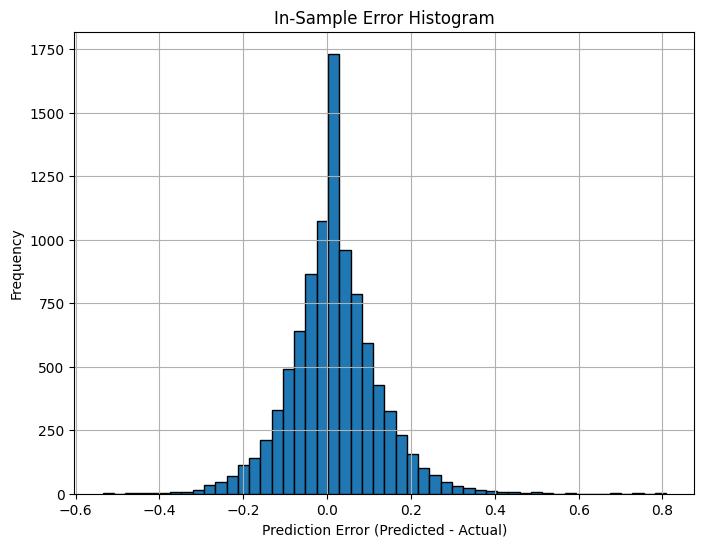

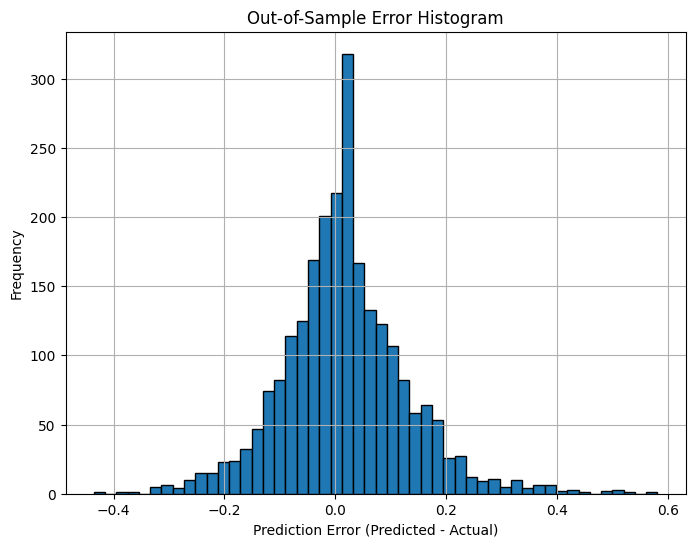

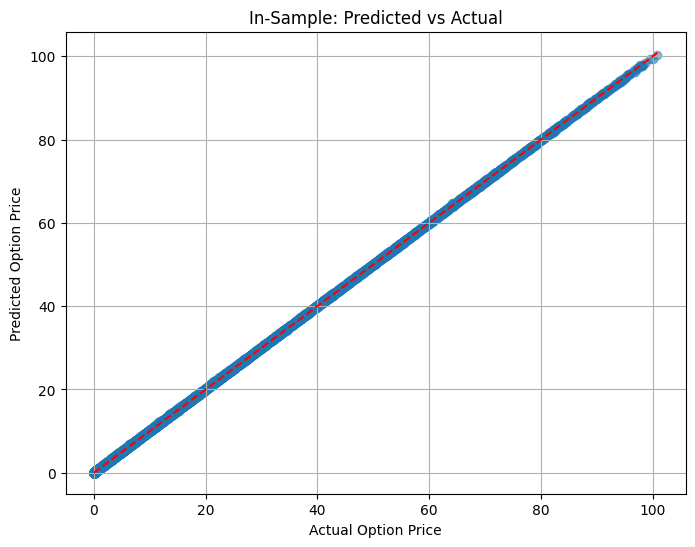

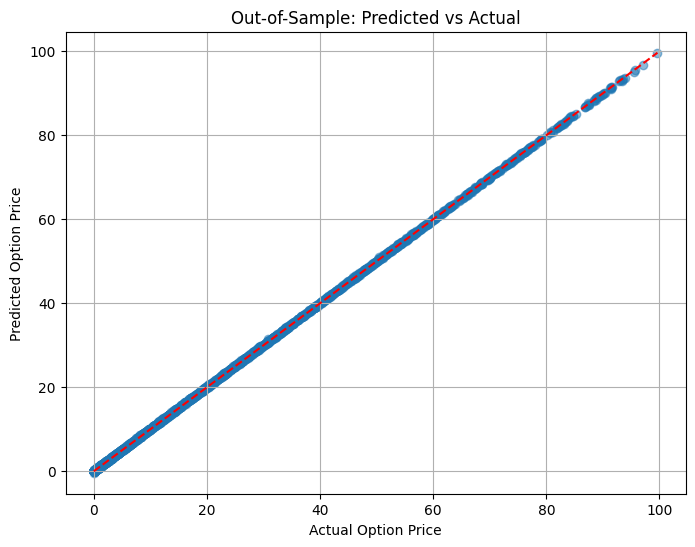


Analysis:
In-Sample MSE: 0.011376, MAE: 0.077574
Out-of-Sample MSE: 0.013057, MAE: 0.082920
  Metric  In-Sample  Out-of-Sample
0    MSE   0.011376       0.013057
1    MAE   0.077574       0.082920


In [12]:
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Black-Scholes Function
def black_scholes_call(S, K, T, r, sigma):
    """
    Computes the Black-Scholes price for a European call option.
    """
    # Avoid division by zero
    T = np.maximum(T, 1e-6)  # Ensure T > 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return np.maximum(call_price, 0)  # Ensure non-negative prices

# Step 2: Generate Synthetic Data
def generate_data(num_samples=12000):
    """
    Samples random BS parameters and computes option prices.
    """
    S = np.random.uniform(50, 150, num_samples)  # Stock price
    K = np.random.uniform(50, 150, num_samples)  # Strike
    T = np.random.uniform(0.1, 2.0, num_samples)  # Time to maturity
    r = np.random.uniform(0.01, 0.05, num_samples)  # Risk-free rate
    sigma = np.random.uniform(0.1, 0.5, num_samples)  # Volatility
    
    prices = black_scholes_call(S, K, T, r, sigma)
    
    # Check for NaNs
    if np.any(np.isnan(prices)):
        raise ValueError("NaN detected in Black-Scholes prices")
    
    X = np.column_stack((S, K, T, r, sigma))
    y = prices.reshape(-1, 1)
    
    return X, y

# Step 3: Normalize Data
def normalize(X):
    """
    Min-max normalization to [0,1] for each feature.
    """
    min_vals = X.min(axis=0)
    max_vals = X.max(axis=0)
    X_norm = (X - min_vals) / (max_vals - min_vals)
    return X_norm, min_vals, max_vals

# Step 4: Define ANN Model
class OptionPricer(nn.Module):
    """
    Simple MLP for option pricing.
    """
    def __init__(self, input_size=5, hidden_size=64):
        super(OptionPricer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 5: Train the Model with Mini-Batches
def train_model(X_train, y_train, batch_size=64, epochs=1000, lr=0.01):
    model = OptionPricer()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Create DataLoader for mini-batch training
    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_X.size(0)
        
        avg_loss = total_loss / len(X_train)
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    
    return model

# Step 6: Make Predictions
def predict(model, X):
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        preds = model(X_tensor).numpy()
    return preds

# Step 7: Plot Functions
def plot_errors(errors, title):
    """
    Histogram of prediction errors.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=50, edgecolor='black')
    plt.title(title)
    plt.xlabel('Prediction Error (Predicted - Actual)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_results(actual, predicted, title):
    """
    Scatter plot of predicted vs actual.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
    plt.title(title)
    plt.xlabel('Actual Option Price')
    plt.ylabel('Predicted Option Price')
    plt.grid(True)
    plt.show()

# Step 8: Main Execution
if __name__ == '__main__':
    # Generate data
    X, y = generate_data()
    
    # Normalize inputs
    X_norm, min_vals, max_vals = normalize(X)
    
    # Train-test split
    split_idx = int(0.8 * len(X))
    X_train = X_norm[:split_idx]
    y_train = y[:split_idx]
    X_test = X_norm[split_idx:]
    y_test = y[split_idx:]
    
    # Train with mini-batches
    model = train_model(X_train, y_train, batch_size=64)
    
    # Predict
    y_train_pred = predict(model, X_train)
    y_test_pred = predict(model, X_test)
    
    # Errors
    train_errors = y_train_pred - y_train
    test_errors = y_test_pred - y_test
    
    # Plots
    plot_errors(train_errors.flatten(), 'In-Sample Error Histogram')
    plot_errors(test_errors.flatten(), 'Out-of-Sample Error Histogram')
    plot_results(y_train.flatten(), y_train_pred.flatten(), 'In-Sample: Predicted vs Actual')
    plot_results(y_test.flatten(), y_test_pred.flatten(), 'Out-of-Sample: Predicted vs Actual')
    
    # Analysis
    train_mse = np.mean(train_errors ** 2)
    test_mse = np.mean(test_errors ** 2)
    train_mae = np.mean(np.abs(train_errors))
    test_mae = np.mean(np.abs(test_errors))
    
    print("\nAnalysis:")
    print(f"In-Sample MSE: {train_mse:.6f}, MAE: {train_mae:.6f}")
    print(f"Out-of-Sample MSE: {test_mse:.6f}, MAE: {test_mae:.6f}")
    df = pd.DataFrame({
        'Metric': ['MSE', 'MAE'],
        'In-Sample': [train_mse, train_mae],
        'Out-of-Sample': [test_mse, test_mae]
    })
    print(df)